## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn.functional as F
from torch.autograd import Variable
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

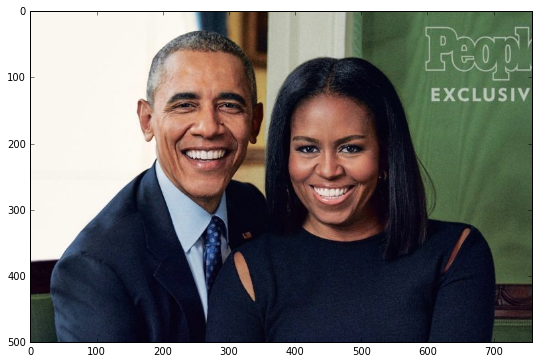

In [13]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


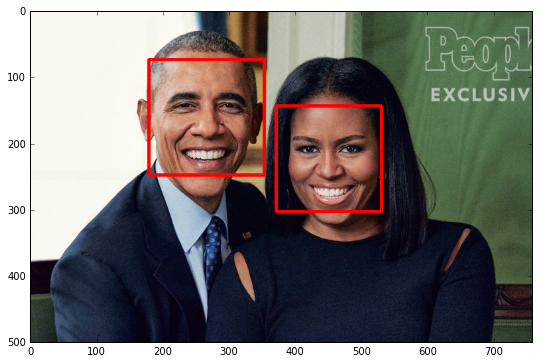

In [14]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [15]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        self.N = 144*256 #12800, 144*256
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 4)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 2)
        self.conv5 = nn.Conv2d(256, 512, 2)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.pool4 = nn.MaxPool2d(2)
        self.pool5 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)
        self.dropout5 = nn.Dropout(0.2)
        self.dropout6 = nn.Dropout(0.2)
        self.dropout7 = nn.Dropout(0.2)
        self.Dense1 = nn.Linear(self.N, 2000)
        self.Dense2 = nn.Linear(2000, 1000)
        self.Dense3 = nn.Linear(1000, 136)
        
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        

        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        ## x = self.pool(F.relu(self.conv1(x)))
        x = self.pool1(F.elu(self.conv1(x)))  # 1, 2, 3, 4
        x = self.dropout1(x) # 5
        x = self.pool2(F.elu(self.conv2(x)))  # 6, 7, 8
        x = self.dropout2(x) # 9
        x = self.pool3(F.elu(self.conv3(x))) # 10, 11, 12
        x = self.dropout3(x) # 13
        x = self.pool4(F.elu(self.conv4(x))) # 14, 15, 16
        x = self.dropout4(x) # 17
#         x = self.pool5(F.elu(self.conv5(x))) # 
#         x = self.dropout5(x) # 
        x = x.view(-1,self.N) # 18
        x = F.elu(self.Dense1(x)) # 19, 20
        x = self.dropout6(x) # 21
        x = F.relu(self.Dense2(x)) # 22, 23
        x = self.dropout7(x)
        x = self.Dense3(x)
        # a modified x, having gone through all the layers of your model, should be returned
        return x

In [21]:
net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_1_short_sqrt.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net (
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (pool3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (pool4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (pool5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (dropout1): Dropout (p = 0.1)
  (dropout2): Dropout (p = 0.1)
  (dropout3): Dropout (p = 0.2)
  (dropout4): Dropout (p = 0.2)
  (dropout5): Dropout (p = 0.2)
  (dropout6): Dropout (p = 0.2)
  (dropout7): Dropout (p = 0.2)
  (Dense1): Linear (36864 -> 2000)
  (Dense2): Linear (2000 -> 1000)
  (Dense3): Linear (1000 -> 136)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




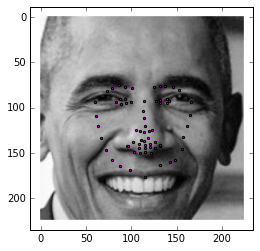

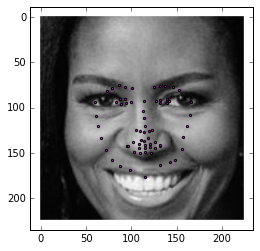

In [31]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y:y+h, x:x+w]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi / 255.
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    t_roi = Variable(torch.from_numpy(roi).view(1, 1, 224, 224).cpu())
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ## perform a forward pass to get the predicted facial keypoints
    r = net(t_roi.type(torch.FloatTensor))
    ## TODO: Display each detected face and the corresponding keypoints  
    r = r.view(68, 2).data.numpy()
    r = r * 50. +100
    plt.imshow(roi, cmap='gray')
    plt.scatter(r[:, 0], r[:, 1], s=20, marker='.', c='m')
    plt.show()
    
        
